In [2]:
import csv
import numpy as np
import ROOT as rt
from glob import glob
donotdelete = []

Welcome to JupyROOT 6.13/02


In [3]:
#f = open('../data/181018_wrapping_test_SensLJ/Na22_12x12x4_SensLJ_OV30p0_MaskWrapping.csv')
#f = open('../data/181019_wrappin_crystal_test_SensLJ/Na22_12x12x4_SensLJ_OV30p0_SiWrapping_v3.csv')
#f = open('../data/181019_wrappin_crystal_test_SensLJ/Na22_Bar3x3x50_SensLJ_OV30p0_blackholder.csv')
#f = open('../data/181020_crystal_test/Na22_7x7x4_SensLJ_OV30p0_Siwrapping.csv')
#f = open('../data/181020_crystal_test/Na22_5x5x4_SensLJ_OV30p0_Siwrapping_v5.csv')
# f = open('../data/181022_ham/Na22_7p8x7p8x4_tile-roughedges_3x3mm_Ham25um_SMA_OV58p0.csv')
#f = open('../data/181022_ham/Na22_3x3x50_bar_twoSided_3x3mm_sensLJ_Lautaroboard_OV30p0_sipm2.csv')

# f = open('../data/181026_sensl_30V_crystal_bar_tile_lce_measurement_Na22/tile_8x8x4_na22_sensl_serial4_30V_V1.csv')
# f = open('../data/18_10_29_Na22_OV30V_AMP52+/Na22_tile_8x8x4_SensL_J_5_OV30V_AMP52+.csv')
# f = open('../data/181102_Na22_SensL_Bar_3x3x50_OV30V/Na22_Bar_3x3x50_onesided_otherside_exposed_SensL_J_33_3_newholder_OV30V.csv')

# f = open('../data/181101_Na22_Sensl_C_33_20_1_OV30V_NoExtAmp/Na22_8x8x4mm_SensL_C_33_20_1_OV30V_NoExtAmp.csv')
# f = open('../data/181107_SensL_crystal_test/Na22_3x3x50_bar_onesided_othersideexposed_Snl_44J35_2_OV30V_th8mV_v2.csv')
f = open('../data/190523_doe_visit/SenslC_Na22_Trg4mV.csv')
content = csv.reader(f)

Amp_x_R = 50 * 10

x = []
y = []
for r in content:
#     x.append(1e12*float(r[0]) / Amp_x_R)
    x.append(1e9*float(r[0]))#nVs
    y.append(float(r[1]))

h = rt.TH1F('h', 'h', int(len(x)), x[0], x[-1])
# h.GetXaxis().SetLimits(h.FindBin(-300), h.FindBin(0))
h.SetXTitle('Charge [pC]')
h.SetYTitle('Events / {:1.1e} pC'.format(h.GetBinWidth(1)))
for i in range(len(x)):
    h.SetBinContent(i+1, y[i])

In [4]:
SS = rt.TSpectrum()
n_pks = SS.Search(h, 0.1, "", 0.02)
x_pos = SS.GetPositionX()
y_pos = SS.GetPositionY()
pks = []
print n_pks


5


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [5]:

# Energy = np.array([0.341, 0.511, 1.057, 1.27])
Energy = np.ones((n_pks,))*0.511
print(Energy.shape,Energy[0])
#Energy = np.array([0, 0.511])
N_pe = 0*Energy

#gain = 76005 # gain of SensL J1 (one that Cristian broke)
# gain = 76220.3 #gain of sensL j_2
# gain = 73471.6 # sensL J_5 with 52+
# gain = 80470.4 #sensL J_4 74+
# gain = 24808.7 # gain of Hamamatsu surface mount, S13360-1325PE
# gain = 42073.8 # sensL C 3x3
# PDE = 0.4 # PDE assumption for SensL J series
# PDE = 0.25 # pde of hamamatsu surface mount from spec sheet, at V = 58V, V_over = 5V
# PDE = 0.31 #sensL C 3x3

gain = 46653.6 #sensL_44J35_2
PDE = 0.5

peaks = []
Ch2N = 1.0e-12/1.6e-19

for i in range(n_pks):
    if i < n_pks-1 and i > 0: continue
    print i, ':', 'E = {:.3f} MeV'.format(Energy[i])
    n_pk = h.FindBin(x_pos[i])
    
#     if i in [0, 2]:
#         print 'Not used'
#         print '\n'
#         continue
    
    if i == 0:
        thr = 0.4 * h.GetBinContent(n_pk)
    else:
        thr = 0.4 * h.GetBinContent(n_pk)
            
    
    n_low = n_pk
    while h.GetBinContent(n_low) > thr:
        n_low -= 1
    x_low = h.GetBinCenter(n_low)    
    
        
    n_up = n_pk
    while h.GetBinContent(n_up) > thr:
        n_up += 1
    x_up = h.GetBinCenter(n_up)
    
    r = h.Fit('gaus', 'LRSQ+', '', x_low, x_up)
    r = r.Get()
    
    print 'Deposited charge: {:.1f} pC (Ne = {:.0f}M)'.format(r.Parameter(1), 1e-6*r.Parameter(1)*Ch2N)
    print 'Fit p-val = {:.2f}'.format(r.Prob())
    print('number in nVs',r.Parameter(1))
    print 'N_pe: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*Energy[i]))
    print 'N_ph: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in N_ph {:.0f}'.format(r.ParError(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in pC {:.0f}'.format(r.ParError(1)*1000)
    peaks.append(r.Parameter(1))

#     N_pe[i] = r.Parameter(1)*Ch2N / (gain * Energy[i])
    
    integral = r.Parameter(0) * np.sqrt(2*np.pi) * r.Parameter(2) / h.GetBinWidth(1)
    print 'Estimated number of decays: {:.0f}'.format(integral)
    print '\n'
    
# aux = np.polyfit(Energy[[1,3]], N_pe[[1,3]], 1)
# m = aux[0]
# offset = aux[1]

# print 'N_pe = {:.1f} * E[MeV] + {:.1f}'.format(m, offset)
# print 'Expected @ 4MeV = {:.0f}'.format(m*4. + offset)
# print('peak difference',peaks[1]-peaks[0])



((5,), 0.511)
0 : E = 0.511 MeV
Deposited charge: 3.6 pC (Ne = 22M)
Fit p-val = 0.01
('number in nVs', 3.5825399535758202)
N_pe: 939
N_ph: 1878
uncertainty in N_ph 0
uncertainty in pC 1
Estimated number of decays: 102183


4 : E = 0.511 MeV
Deposited charge: 7.8 pC (Ne = 49M)
Fit p-val = 0.07
('number in nVs', 7.813414647400569)
N_pe: 2048
N_ph: 4097
uncertainty in N_ph 2
uncertainty in pC 4
Estimated number of decays: 10113




Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_spectrum


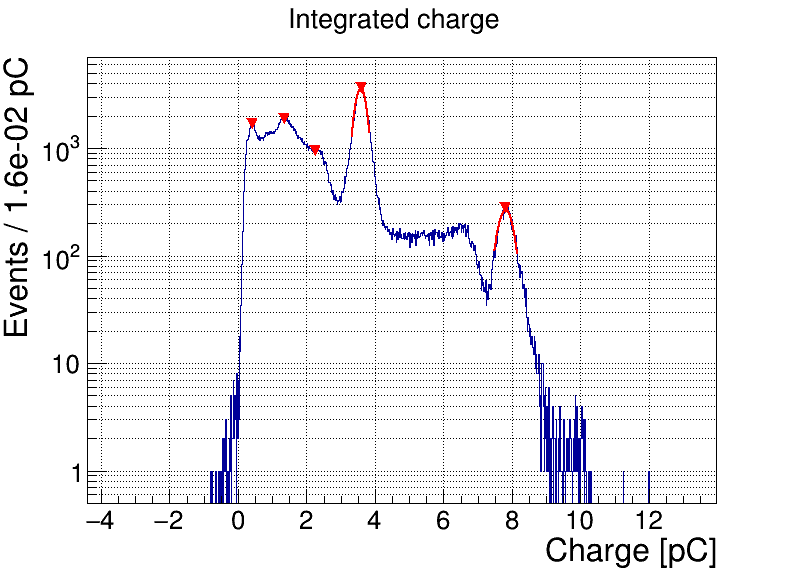

In [31]:

c = rt.TCanvas('c_spectrum', 'c_spectrum', 800, 600)
#rt.gStyle.SetOptFit(000002200)
rt.gStyle.SetOptFit(000002200)
# rt.gStyle.SetTitleSize(0.8)



h.SetStats(0)
h.SetTitle('Integrated charge')
h.GetXaxis().SetRangeUser(-20,60)
h.GetXaxis().SetTitleSize(0.06)
h.GetXaxis().SetTitleOffset(0.9)
h.GetXaxis().SetLabelSize(0.05)

h.GetYaxis().SetTitleSize(0.06)
h.GetYaxis().SetTitleOffset(0.9)
h.GetYaxis().SetLabelSize(0.05)

c.SetLeftMargin(0.11)
c.SetBottomMargin(0.12)


h.DrawCopy()
c.SetLogy()
c.SetGrid()
c.Draw()
donotdelete.append(c)